 # Medical Cost Personal Datasets
 # Insurance Forecast by using Linear Regression

https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

 ## 1. Data upload and first study

In [99]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import optuna
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [14]:
# Data upload
df = pd.read_csv('/Users/macbook/Desktop/Yandex Mashine Learning/Kaggle/Insurance/insurance.csv')

In [16]:
# First study
display(df.info())
display(df.head(10))
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [18]:
# Check duplicates
df.duplicated().sum()

1

In [20]:
# Delete duplicate
df.drop_duplicates(inplace=True)

In [27]:
# Check other duplicate
object_columns = [col for col in df.select_dtypes(include=['object']).columns if col not in ['DateCrawled', 'DateCreated', 'LastSeen']]



for col in object_columns:
    print(df[col].value_counts())
    print()

sex
male      675
female    662
Name: count, dtype: int64

smoker
no     1063
yes     274
Name: count, dtype: int64

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64



 ## 2. Analysis of data

In [25]:
# Building histogram
plt.figure(figsize=(100, 100)) # size's matrix of histogram
df_describe = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']] # choice all features
num_cols = 2 # Amount of columns
num_rows = (len(df_describe.columns) + num_cols - 1) // num_cols # Amount of ranges
total_plots = num_cols * num_rows # Size of matrix

def count_bin(col): # Function for a return of amount of bins
    return len(df_describe[col].unique()) if len(df_describe[col].unique())<10 else 15

# Using cycle we create a histogram of distribution for every column
for i, col in enumerate(df_describe.columns):
    plt.rcParams.update({'font.size': 50})  # Setting the size of type for title 
    plt.rcParams.update({'axes.labelsize': 50})  # Setting the size of type for axis 
    plt.subplot(num_rows, num_cols, i+1) # Choice histogram for "i" in matrix
    plt.hist(df_describe[col], bins=count_bin(col)) # Building histogram for every column
    plt.title(col) # Assignment title for every column
    plt.xlabel('Значение')
    plt.ylabel('Частота')

plt.tight_layout() # Starting the function for automatic regulation of elemnts
plt.show()

 #### Build box-plots for every numerical columns

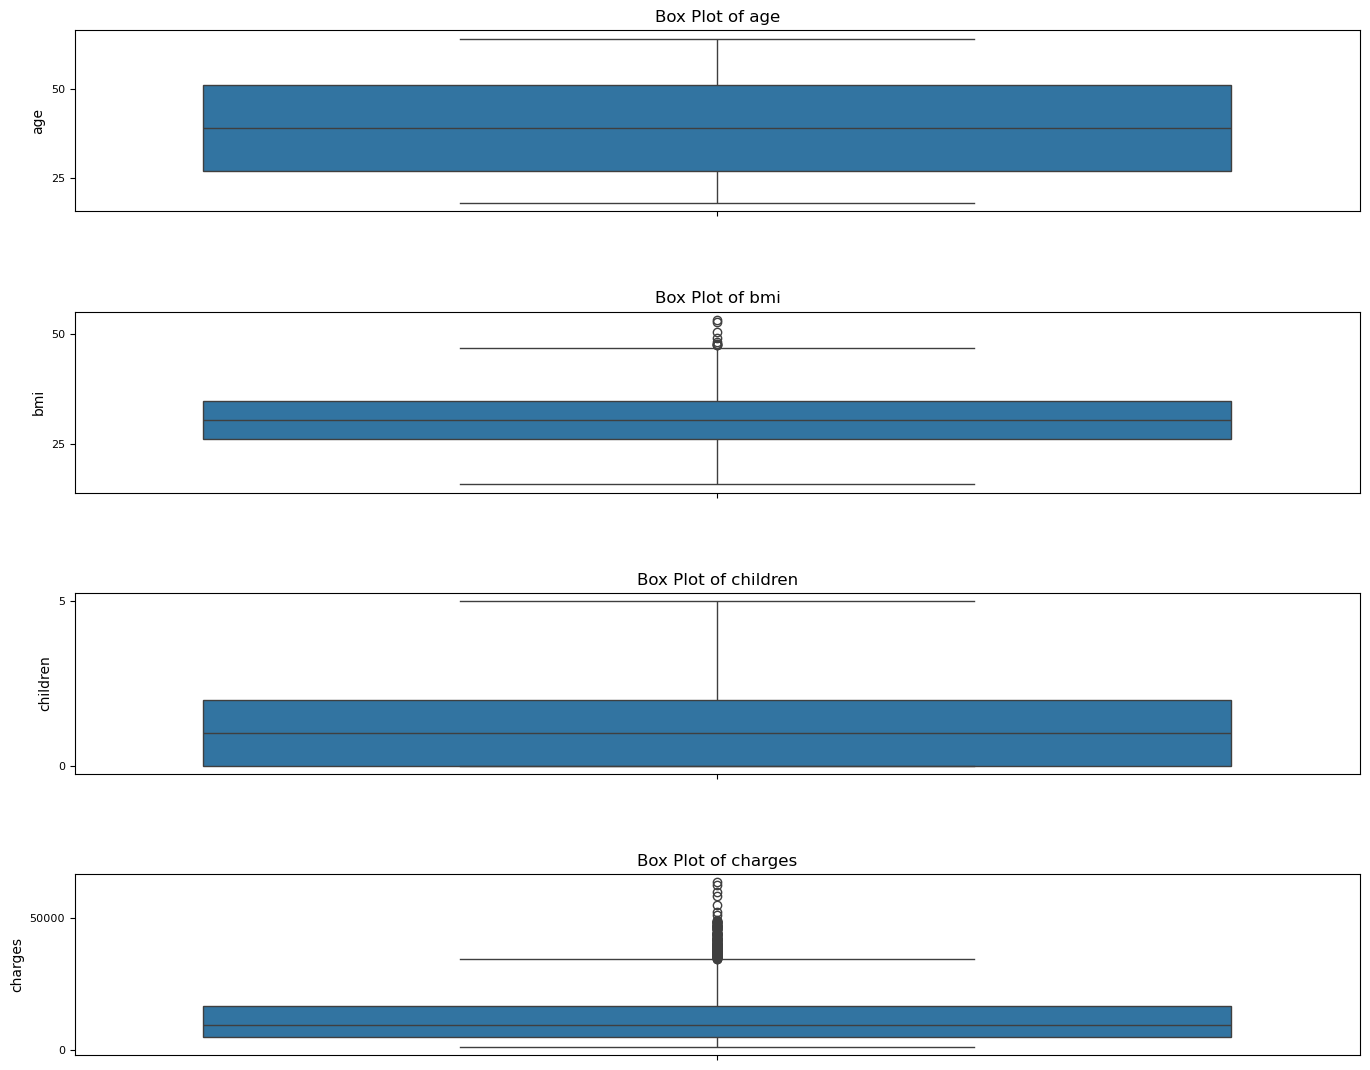

In [33]:
# Создание боксплотов для каждой числовой характеристики
numerical_features = df.select_dtypes(include=['number'])

# Определяем размер фигуры один раз
plt.figure(figsize=(15, 12))

# Создаем подграфики для каждого числового признака
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features.columns), 1, i + 1)  # Создаем подграфик
    sns.boxplot(data=df, y=feature)
    plt.title(f'Box Plot of {feature}', fontsize=12)  # Размер шрифта заголовка
    plt.ylabel(feature, fontsize=10)  # Размер шрифта метки оси Y
    plt.xlabel('')  # Убираем метку оси X, если она не нужна
    
    # Увеличиваем размер шрифта меток на осях
    plt.xticks(fontsize=8)  # Размер шрифта меток на оси X
    plt.yticks(fontsize=8)  # Размер шрифта меток на оси Y

plt.tight_layout()  # Автоматически подгоняет подграфики
plt.show()

In [37]:
# Replace male by 1 and female by 1 in column sex
df['sex'] = df['sex'].replace({'male': 1, 'female': 0})

# Replace yes by 1 and no by 1 in column smoker
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})

 #### Build a matrix of dependences for target

interval columns not set, guessing: ['age', 'sex', 'bmi', 'children', 'smoker', 'charges']


<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/b4/mc0v_4c562xfny9p49bm920h0000gn/T/ipykernel_3479/352057533.py:9: SyntaxWarning: invalid escape sequence '\p'
  title='Корреляция $\phi_k$',


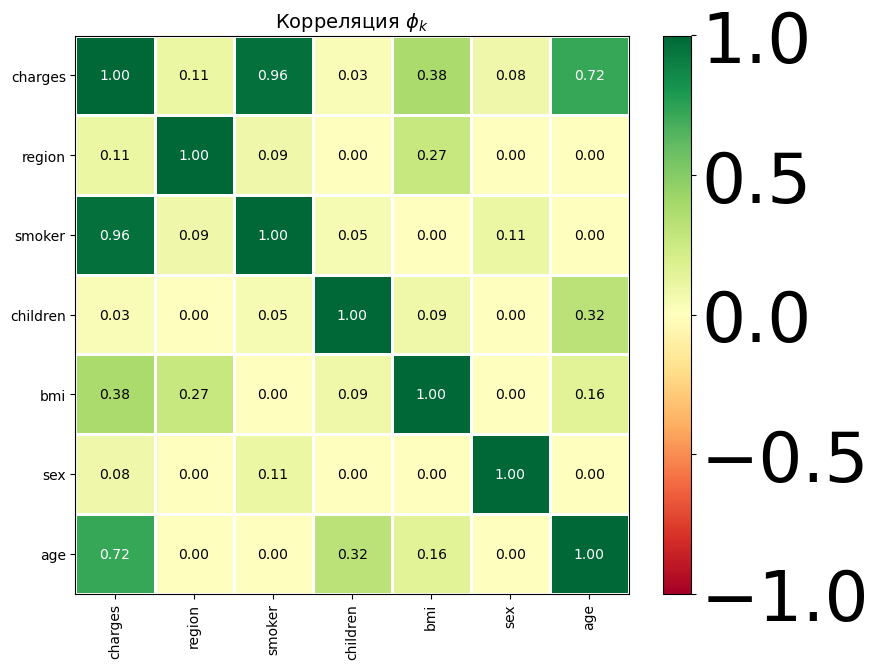

In [48]:
# Receive a correlation
phik_corr = df.phik_matrix()

# Build   
plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    title='Корреляция $\phi_k$',
    identity_layout=True,
    figsize=(10, 8)
)


 ## Data preparation

In [51]:
df = pd.get_dummies(df, drop_first=True)

# Select a features and target
features = df.drop(['charges'], axis=1)
target = df['charges']

# Part a data for train and test
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=12345, test_size=0.2)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)


# Check a target in train data and test data
print('Train data', target_train.value_counts())
print()
print('Test data', target_test.value_counts())

Train data charges
1241.56500     1
9386.16130     1
6985.50695     1
4349.46200     1
13390.55900    1
              ..
18033.96790    1
36021.01120    1
39047.28500    1
13635.63790    1
1622.18850     1
Name: count, Length: 1069, dtype: int64

Test data charges
9583.89330     1
2203.47185     1
11944.59435    1
46889.26120    1
9411.00500     1
              ..
7077.18940     1
12224.35085    1
17361.76610    1
10450.55200    1
12950.07120    1
Name: count, Length: 268, dtype: int64


 #### Write the function for metrics

In [56]:
def metrics(predictions, target):
    mae = mean_absolute_error(target, predictions)
    mse = mean_squared_error(target, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(target, predictions)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R_2': r_squared}

 ### Train Linear Regression model

In [75]:
fit_intercepts = [True, False]
best_result = 0
linear_regres, best_fit_intercept = None, None

for fit_intercept in fit_intercepts:
    model = LinearRegression(fit_intercept=fit_intercept)
    
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
    result = np.mean(scores)  

    if result > best_result:
        linear_regres = model
        best_result = result
        best_fit_intercept = fit_intercept



# Train model
linear_regres.fit(features_train, target_train)

# Received predictions
predictions = linear_regres.predict(features_test)

lin_reg = metrics(predictions, target_test)


print(f'The best parameters: fit_intercept={best_fit_intercept}, normalize={best_normalize}')
print(f'Metrics: {lin_reg}')

The best parameters: fit_intercept=True, normalize=None
Metrics: {'MAE': 4052.4979502922306, 'MSE': 35076318.966109075, 'RMSE': 5922.526400625756, 'R_2': 0.7687765137382273}


 #### Train DecisionTree Model

In [81]:
min_samples_splits = [2, 5, 10]
best_result = 0
best_params = None
decision_tree_regressor = None

for max_depth in range(1, 16):
    for min_samples_split in min_samples_splits:
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores)  

        if result > best_result:
            decision_tree_regressor = model
            best_result = result
            best_params = (max_depth, min_samples_split)

# Train model
decision_tree_regressor.fit(features_train, target_train)

# Receive predictions
predictions = decision_tree_regressor.predict(features_test)


dec_reg = metrics(predictions, target_test)

print(f'The best parameters: max_depth={best_params[0]}, min_samples_split={best_params[1]}')
print(f'Metrics: {dec_reg}')

The best parameters: max_depth=4, min_samples_split=2
Metrics: {'MAE': 2623.394062601925, 'MSE': 19708135.044324398, 'RMSE': 4439.384534406137, 'R_2': 0.870083753740822}


 #### Train Randomforest Model

In [83]:
n_estimators_options = [50, 100, 200]
max_depths = range(1, 16)
best_result = 0
best_params = None
random_forest_regressor = None

for n_estimators in n_estimators_options:
    for max_depth in max_depths:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores) 

        if result > best_result:
            random_forest_regressor = model
            best_result = result
            best_params = (n_estimators, max_depth)

# Train model
random_forest_regressor.fit(features_train, target_train)

# Receive predictions
predictions = random_forest_regressor.predict(features_test)

rf_metrics = metrics(predictions, target_test)

print(f'The best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]}')
print(f'Metrics: {rf_metrics}')

The best parameters: n_estimators=100, max_depth=4
Metrics: {'MAE': 2456.943523317969, 'MSE': 17669271.128276788, 'RMSE': 4203.483213749852, 'R_2': 0.8835239674399094}


 #### Train KNeighborsRegressor model

In [89]:
n_neighbors_options = [3, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']
best_result = 0
best_params = None
knn_regressor = None

for n_neighbors in n_neighbors_options:
    for weights in weights_options:
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores)  

        if result > best_result:
            knn_regressor = model
            best_result = result
            best_params = (n_neighbors, weights)

# Train model
knn_regressor.fit(features_train, target_train)

# Receive predictions
predictions = knn_regressor.predict(features_test)

knn_metrics = metrics(predictions, target_test)

print(f'The best parameters: n_neighbors={best_params[0]}, weights={best_params[1]}')
print(f'Metrics: {knn_metrics}')

The best parameters: n_neighbors=10, weights=distance
Metrics: {'MAE': 3002.105941715885, 'MSE': 26382544.749587648, 'RMSE': 5136.394138847568, 'R_2': 0.8260859704420243}


 #### Train LGBMRegressor model

In [93]:
lgbm_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, -1]  # -1 означает отсутствие ограничения
}

best_result_lgbm = 0
best_params_lgbm = None
lgbm_regressor = None

for n_estimators in lgbm_params['n_estimators']:
    for learning_rate in lgbm_params['learning_rate']:
        for max_depth in lgbm_params['max_depth']:
            model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_lgbm:
                lgbm_regressor = model
                best_result_lgbm = result
                best_params_lgbm = (n_estimators, learning_rate, max_depth)

# Обучение модели
lgbm_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_lgbm = lgbm_regressor.predict(features_test)

# Вычисление метрик
lgbm_metrics = metrics(predictions_lgbm, target_test)

print(f'LGBM - The best parameters: n_estimators={best_params_lgbm[0]}, learning_rate={best_params_lgbm[1]}, max_depth={best_params_lgbm[2]}')
print(f'LGBM - Metrics: {lgbm_metrics}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 855, number of used features: 8
[LightGBM] [Info] Start training from score 13516.208267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 #### Train CatBoostRegressor model

In [97]:
catboost_params = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}

best_result_catboost = 0
best_params_catboost = None
catboost_regressor = None

for iterations in catboost_params['iterations']:
    for learning_rate in catboost_params['learning_rate']:
        for depth in catboost_params['depth']:
            model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_catboost:
                catboost_regressor = model
                best_result_catboost = result
                best_params_catboost = (iterations, learning_rate, depth)

# Обучение модели
catboost_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_catboost = catboost_regressor.predict(features_test)

# Вычисление метрик
catboost_metrics = metrics(predictions_catboost, target_test)

print(f'CatBoost - The best parameters: iterations={best_params_catboost[0]}, learning_rate={best_params_catboost[1]}, depth={best_params_catboost[2]}')
print(f'CatBoost - Metrics: {catboost_metrics}')

CatBoost - The best parameters: iterations=100, learning_rate=0.1, depth=3
CatBoost - Metrics: {'MAE': 2328.8779020408897, 'MSE': 17448178.437589902, 'RMSE': 4177.101679105968, 'R_2': 0.8849814129254808}


 #### Train MLPRegressor model

In [103]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300]
}

best_result_mlp = 0
best_params_mlp = None
mlp_regressor = None

for hidden_layer_sizes in mlp_params['hidden_layer_sizes']:
    for activation in mlp_params['activation']:
        for learning_rate_init in mlp_params['learning_rate_init']:
            for max_iter in mlp_params['max_iter']:
                model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                     activation=activation,
                                     learning_rate_init=learning_rate_init,
                                     max_iter=max_iter,
                                     random_state=42,
                                     verbose=0)
                
                scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
                result = np.mean(scores)

                if result > best_result_mlp:
                    mlp_regressor = model
                    best_result_mlp = result
                    best_params_mlp = (hidden_layer_sizes, activation, learning_rate_init, max_iter)

# Обучение модели
mlp_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_mlp = mlp_regressor.predict(features_test)

# Вычисление метрик
mlp_metrics = metrics(predictions_mlp, target_test)

print(f'MLP - The best parameters: hidden_layer_sizes={best_params_mlp[0]}, activation={best_params_mlp[1]}, learning_rate_init={best_params_mlp[2]}, max_iter={best_params_mlp[3]}')
print(f'MLP - Metrics: {mlp_metrics}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

MLP - The best parameters: hidden_layer_sizes=(100,), activation=relu, learning_rate_init=0.1, max_iter=300
MLP - Metrics: {'MAE': 2818.6555189800324, 'MSE': 21599453.593437556, 'RMSE': 4647.5212310905645, 'R_2': 0.8576161607479529}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


 ## Conclusion

In [109]:
# Build a table for total

model_metrics = [lin_reg, dec_reg, rf_metrics, knn_metrics, lgbm_metrics, catboost_metrics, mlp_metrics]

total = pd.DataFrame(model_metrics, index=['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNeighborsClassifier', 'LGBM', 'CatBoost', 'MLPClassifier'])
print(total.sort_values(by='R_2', ascending=False))

                              MAE           MSE         RMSE       R_2
LGBM                  2372.677257  1.706990e+07  4131.574100  0.887475
CatBoost              2328.877902  1.744818e+07  4177.101679  0.884981
RandomForest          2456.943523  1.766927e+07  4203.483214  0.883524
DecisionTree          2623.394063  1.970814e+07  4439.384534  0.870084
MLPClassifier         2818.655519  2.159945e+07  4647.521231  0.857616
KNeighborsClassifier  3002.105942  2.638254e+07  5136.394139  0.826086
LogisticRegression    4052.497950  3.507632e+07  5922.526401  0.768777


 ### Improving metrics

 #### LGBMRegressor optimized with optuna

In [114]:
def objective(trial):
    # Определяем диапазоны для гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 50)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        random_state=42
    )

    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)  # Используем тестовую выборку
    mse = mean_squared_error(target_test, y_pred)

    return mse  # Минимизируем MSE

# Создаем объект исследования Optuna
study = optuna.create_study(direction='minimize')  # Мы минимизируем MSE
study.optimize(objective, n_trials=30)

# Получаем лучшие параметры
best_params = study.best_params
print(best_params)

[I 2024-11-14 20:40:55,301] A new study created in memory with name: no-name-4ffdb93d-082b-43ce-afdd-bd7b9889de50


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13268.013144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-11-14 20:40:55,533] Trial 0 finished with value: 80785145.7039587 and parameters: {'n_estimators': 334, 'learning_rate': 0.0011290433637152252, 'max_depth': 15, 'num_leaves': 52, 'min_child_samples': 30}. Best is trial 0 with value: 80785145.7039587.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13268.013144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-11-14 20:40:55,838] Trial 1 finished with value: 37916152.17985149 and parameters: {'n_estimators': 491, 'learning_rate': 0.0019238047661395072, 'max_depth': 15, 'num_leaves': 139, 'min_child_samples': 32}. Best is trial 1 with value: 37916152.17985149.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:56,008] Trial 2 finished with value: 27031506.413252756 and parameters: {'n_estimators': 139, 'learning_rate': 0.009572222646631035, 'max_depth': 9, 'num_leaves': 113, 'min_child_samples': 19}. Best is trial 2 with value: 27031506.413252756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:56,177] Trial 3 finished with value: 19928503.88726957 and parameters: {'n_estimators': 305, 'learning_rate': 0.0854417249723537, 'max_depth': 8, 'num_leaves': 83, 'min_child_samples': 34}. Best is trial 3 with value: 19928503.88726957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:56,380] Trial 4 finished with value: 21420182.49316919 and parameters: {'n_estimators': 429, 'learning_rate': 0.003952391583726472, 'max_depth': 4, 'num_leaves': 106, 'min_child_samples': 4}. Best is trial 3 with value: 19928503.88726957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:56,640] Trial 5 finished with value: 47010221.42020718 and parameters: {'n_estimators': 393, 'learning_rate': 0.0019773988637272416, 'max_depth': 12, 'num_leaves': 149, 'min_child_samples': 42}. Best is trial 3 with value: 19928503.88726957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:57,130] Trial 6 finished with value: 27270524.531542104 and parameters: {'n_estimators': 292, 'learning_rate': 0.20526130472950657, 'max_depth': 15, 'num_leaves': 49, 'min_child_samples': 9}. Best is trial 3 with value: 19928503.88726957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 secon

[I 2024-11-14 20:40:57,827] Trial 7 finished with value: 19532479.165762436 and parameters: {'n_estimators': 449, 'learning_rate': 0.005107590178166746, 'max_depth': 10, 'num_leaves': 29, 'min_child_samples': 1}. Best is trial 7 with value: 19532479.165762436.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13268.013144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-11-14 20:40:58,205] Trial 8 finished with value: 17840343.401934005 and parameters: {'n_estimators': 471, 'learning_rate': 0.008461009870851842, 'max_depth': 6, 'num_leaves': 135, 'min_child_samples': 49}. Best is trial 8 with value: 17840343.401934005.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:58,447] Trial 9 finished with value: 22370713.652191296 and parameters: {'n_estimators': 438, 'learning_rate': 0.14258794345389672, 'max_depth': 6, 'num_leaves': 131, 'min_child_samples': 33}. Best is trial 8 with value: 17840343.401934005.
[I 2024-11-14 20:40:58,502] Trial 10 finished with value: 17211652.95736431 and parameters: {'n_estimators': 157, 'learning_rate': 0.033344574767982665, 'max_depth': 3, 'num_leaves': 92, 'min_child_samples': 50}. Best is trial 10 with value: 17211652.95736431.
[I 2024-11-14 20:40:58,550] Trial 11 finished with value: 17179415.96115148 and parameters: {'n_estimators': 160, 'learning_rate': 0.03862941209664749, 'max_depth': 3, 'num_leaves': 88, 'min_child_samples': 48}. Best is trial 11 with value: 17179415.96115148.
[I 2024-11-14 20:40:58,593] Trial 12 finished with value: 17176821.02240366 and parameters: {'n_estimators': 148, 'learning_rate': 0.03745612418873909, 'max_depth': 3, 'num_leaves': 83, 'min_child_samples': 50}. Best i

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13268.013144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-11-14 20:40:58,712] Trial 14 finished with value: 17378869.888951566 and parameters: {'n_estimators': 200, 'learning_rate': 0.045390133103191635, 'max_depth': 3, 'num_leaves': 68, 'min_child_samples': 41}. Best is trial 12 with value: 17176821.02240366.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13268.013144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-11-14 20:40:58,988] Trial 15 finished with value: 18175055.49640707 and parameters: {'n_estimators': 225, 'learning_rate': 0.018123658978104126, 'max_depth': 6, 'num_leaves': 105, 'min_child_samples': 22}. Best is trial 12 with value: 17176821.02240366.
[I 2024-11-14 20:40:59,053] Trial 16 finished with value: 17801913.580078013 and parameters: {'n_estimators': 68, 'learning_rate': 0.07066163377296086, 'max_depth': 8, 'num_leaves': 86, 'min_child_samples': 47}. Best is trial 12 with value: 17176821.02240366.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:59,125] Trial 17 finished with value: 19388946.81856027 and parameters: {'n_estimators': 121, 'learning_rate': 0.018207068758610258, 'max_depth': 4, 'num_leaves': 64, 'min_child_samples': 38}. Best is trial 12 with value: 17176821.02240366.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:59,407] Trial 18 finished with value: 28415206.561329562 and parameters: {'n_estimators': 233, 'learning_rate': 0.27990869556580095, 'max_depth': 11, 'num_leaves': 117, 'min_child_samples': 14}. Best is trial 12 with value: 17176821.02240366.
[I 2024-11-14 20:40:59,448] Trial 19 finished with value: 17216742.912803896 and parameters: {'n_estimators': 103, 'learning_rate': 0.10887164492761964, 'max_depth': 3, 'num_leaves': 95, 'min_child_samples': 26}. Best is trial 12 with value: 17176821.02240366.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:59,529] Trial 20 finished with value: 17996111.981030088 and parameters: {'n_estimators': 196, 'learning_rate': 0.05060621703082344, 'max_depth': 5, 'num_leaves': 22, 'min_child_samples': 46}. Best is trial 12 with value: 17176821.02240366.
[I 2024-11-14 20:40:59,580] Trial 21 finished with value: 17218305.506047163 and parameters: {'n_estimators': 171, 'learning_rate': 0.02904560863618829, 'max_depth': 3, 'num_leaves': 85, 'min_child_samples': 50}. Best is trial 12 with value: 17176821.02240366.
[I 2024-11-14 20:40:59,637] Trial 22 finished with value: 17408235.91451339 and parameters: {'n_estimators': 155, 'learning_rate': 0.029168479475000963, 'max_depth': 4, 'num_leaves': 96, 'min_child_samples': 44}. Best is trial 12 with value: 17176821.02240366.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:59,768] Trial 23 finished with value: 17913260.943316102 and parameters: {'n_estimators': 245, 'learning_rate': 0.012760538728816606, 'max_depth': 7, 'num_leaves': 76, 'min_child_samples': 38}. Best is trial 12 with value: 17176821.02240366.
[I 2024-11-14 20:40:59,814] Trial 24 finished with value: 17738068.06061862 and parameters: {'n_estimators': 98, 'learning_rate': 0.05548773025732281, 'max_depth': 5, 'num_leaves': 53, 'min_child_samples': 50}. Best is trial 12 with value: 17176821.02240366.
[I 2024-11-14 20:40:59,863] Trial 25 finished with value: 16989294.74125603 and parameters: {'n_estimators': 172, 'learning_rate': 0.02889772521195106, 'max_depth': 3, 'num_leaves': 91, 'min_child_samples': 38}. Best is trial 25 with value: 16989294.74125603.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:40:59,937] Trial 26 finished with value: 17360601.597275484 and parameters: {'n_estimators': 191, 'learning_rate': 0.02148471744949211, 'max_depth': 4, 'num_leaves': 121, 'min_child_samples': 38}. Best is trial 25 with value: 16989294.74125603.
[I 2024-11-14 20:41:00,059] Trial 27 finished with value: 20622936.325130116 and parameters: {'n_estimators': 264, 'learning_rate': 0.1284118162215225, 'max_depth': 13, 'num_leaves': 100, 'min_child_samples': 45}. Best is trial 25 with value: 16989294.74125603.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:41:00,143] Trial 28 finished with value: 33785305.81238434 and parameters: {'n_estimators': 95, 'learning_rate': 0.010960697391389863, 'max_depth': 7, 'num_leaves': 75, 'min_child_samples': 28}. Best is trial 25 with value: 16989294.74125603.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-14 20:41:00,293] Trial 29 finished with value: 18964973.561262053 and parameters: {'n_estimators': 342, 'learning_rate': 0.0068335471872801945, 'max_depth': 5, 'num_leaves': 60, 'min_child_samples': 36}. Best is trial 25 with value: 16989294.74125603.


{'n_estimators': 172, 'learning_rate': 0.02889772521195106, 'max_depth': 3, 'num_leaves': 91, 'min_child_samples': 38}


In [118]:
model = LGBMRegressor(
        n_estimators=172,
        learning_rate=0.02889772521195106,
        max_depth=3,
        num_leaves=91,
        min_child_samples=38,
        random_state=42
    )



model.fit(features_train, target_train)

y_pred = model.predict(features_test)

mse = mean_squared_error(target_test, y_pred)

total_metrics = metrics(y_pred, target_test)

print(f"Accuracy of MLPClassifier model with specified parameters: {mse}")
print(f"All metrics: {total_metrics}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13268.013144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain